In [82]:
# Libraries (will need to export to requirements.txt)

import wptools
from bs4 import BeautifulSoup
from SPARQLWrapper import SPARQLWrapper, JSON
import nltk
#nltk.download('punkt')
import pandas as pd
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Pull 100 biographies from wikipedia for each category

In [2]:
category1 = 'actors' # Give the category of entities for the first category
category2 = 'list of inventors' # Give the category of entities for the second category

In [3]:
def is_person(name):
    """
    :param str name: name of an object
    :return bool: whether the object is a person
    """
    
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    
    modified_name = name.replace(' ', '_').replace("'", '%27')
    
    query = """
            ASK {
                dbr:%s a dbo:Person .
            }
            """ % modified_name
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        result = sparql.query().convert()
        return result['boolean']
    except:
        return False

In [4]:
def populate_people(category, limit=50):
    """
    :param str category: category to search for people in
    :return list: contains the links to wikipedia pages
    """
    people = []
    page = wptools.page(category)
    query = page.get_query()
    for w in query.data['links']:
        if is_person(w):
            people.append(w)
            if len(people) > limit - 1:
                break
    return people

In [5]:
people1 = populate_people(category1, limit=5)
people2 = populate_people(category2, limit=5)

en.wikipedia.org (query) actors
en.wikipedia.org (imageinfo) File:William Hogarth - David Garrick...
Actor (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(3)> actors, actresses, actress
  assessments: <dict(5)> Television, Film, Theatre, Radio, Occupations
  description: <str(98)> person who acts in a dramatic or comic pr...
  extext: <str(1509)> An **actor** or **actress** is a person who ...
  extract: <str(1753)> <link rel="mw-deduplicated-inline-style" hr...
  image: <list(2)> {'kind': 'query-pageimage', 'file': 'File:Willi...
  label: actor
  length: 44,885
  links: <list(348)> 4th century, 5th centuries, A Funny Thing Hap...
  modified: <dict(1)> page
  pageid: 21504235
  random: Philip Selway
  redirected: <list(1)> {'from': 'Actors', 'to': 'Actor'}
  redirects: <list(23)> {'pageid': 648, 'ns': 0, 'title': 'Actress...
  requests: <list(2)> query, imageinfo
  title: Actor
  url: https://en.wikipedia.org/wiki/Actor
  url_raw: https://en.wikipedia.org/wiki/Actor?action=

In [6]:
print(people1)
print(people2)

['Acting instructor', 'Actor-manager', 'Adam de la Halle', 'Albert Capellani', 'Animator']
['A. Baldwin Wood', 'Abd al-Rahman al-Sufi', 'Abram Alikhanov', 'Abu-Mahmud Khojandi', 'Abū Ishāq Ibrāhīm al-Zarqālī']


In [13]:
def get_text(page):
    try:
        page = wptools.page(page)
        query = page.get()
        return query.data['wikitext']
    except:
        return ""

In [9]:
df = pd.DataFrame({'people' : people1+people2})

In [10]:
df['category'] = pd.Series([category1]*len(people1) + [category2]*len(people2))

In [14]:
df['text'] = df['people'].apply(get_text)

en.wikipedia.org (query) Acting instructor
en.wikipedia.org (parse) 15098680
www.wikidata.org (wikidata) Q4676869
www.wikidata.org (labels) Q12737077|Q28640|P2521|P460|P1889|P2163...
en.wikipedia.org (restbase) /page/summary/Acting_instructor
Acting instructor (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(3)> acting teacher, acting professor, acting coach
  assessments: <dict(2)> Theatre, Occupations
  claims: <dict(10)> P31, P2521, P646, P460, P279, P244, P2163, P1...
  exhtml: <str(305)> <p>An <b>Acting Instructor</b> is a person, u...
  exrest: <str(291)> An Acting Instructor is a person, usually wel...
  extext: <str(291)> An **Acting Instructor** is a person, usually...
  extract: <str(316)> <p>An <b>Acting Instructor</b> is a person, ...
  label: acting instructor
  labels: <dict(14)> Q12737077, Q28640, P2521, P460, P1889, P2163,...
  length: 427
  links: <list(6)> Jacques Lecoq, Methodology, Mime artist, Steven...
  modified: <dict(2)> page, wikidata
  pageid: 1509

en.wikipedia.org (parse) 100533
www.wikidata.org (wikidata) Q4647580
www.wikidata.org (labels) P569|P373|P735|P570|P106|P69|P646|Q6581...
en.wikipedia.org (restbase) /page/summary/A._Baldwin_Wood
en.wikipedia.org (imageinfo) File:A Baldwin Wood Station Dedicati...
A. Baldwin Wood (en) data
{
  WARNINGS: <dict(1)> extracts
  aliases: <list(1)> Albert Baldwin Wood
  assessments: <dict(2)> United States, Biography
  claims: <dict(12)> P569, P570, P31, P21, P106, P69, P735, P373, ...
  description: American inventor and engineer
  exhtml: <str(178)> <p><b>Albert Baldwin Wood</b> was an inventor...
  exrest: <str(164)> Albert Baldwin Wood was an inventor and engin...
  extext: <str(1788)> **Albert Baldwin Wood** (December 1, 1879 – ...
  extract: <str(1889)> <p class="mw-empty-elt"></p><p><b>Albert Ba...
  image: <list(4)> {'kind': 'query-pageimage', 'file': 'File:A Bal...
  label: A. Baldwin Wood
  labels: <dict(17)> P569, P373, P735, P570, P106, P69, P646, Q658...
  length: 3,167
  links:

In [71]:
def clean_text(text):
    dirty_chars = '{}[]()|\/=+`"*,.<>;:#$%&' + "'"
    for char in dirty_chars:
        text = text.replace(char, ' ')
    text = text.lower()
    return nltk.word_tokenize(text)

In [72]:
df['tokenized'] = df['text'].apply(clean_text)

In [73]:
df

,people,category,text,tokenized
0,Acting instructor,actors,{{unreferenced|date=February 2013}}\n\nAn '''A...,"[unreferenced, date, february, 2013, an, actin..."
1,Actor-manager,actors,{{Short description|Actor who manages their ow...,"[short, description, actor, who, manages, thei..."
2,Adam de la Halle,actors,{{short description|French trouvère (1245–50 –...,"[short, description, french, trouvère, 1245–50..."
3,Albert Capellani,actors,{{short description|French film director}}\n{{...,"[short, description, french, film, director, u..."
4,Animator,actors,{{Short description|Person who makes animation...,"[short, description, person, who, makes, anima..."
5,A. Baldwin Wood,list of inventors,{{Short description|American inventor and engi...,"[short, description, american, inventor, and, ..."
6,Abd al-Rahman al-Sufi,list of inventors,{{Short description|Persian astronomer (903–98...,"[short, description, persian, astronomer, 903–..."
7,Abram Alikhanov,list of inventors,{{short description|Soviet nuclear physicist}}...,"[short, description, soviet, nuclear, physicis..."
8,Abu-Mahmud Khojandi,list of inventors,{{Short description|10th-century Persian astro...,"[short, description, 10th-century, persian, as..."
9,Abū Ishāq Ibrāhīm al-Zarqālī,list of inventors,"{{Short description|Muslim astrologer, and ast...","[short, description, muslim, astrologer, and, ..."


In [ ]:
# Create 50 most common word per category and word cloud

In [74]:
def get_all_tokens(df, category):
    tokens = []
    for series in df[df["category"] == category]['tokenized']:
        for t in series:
            tokens.append(t)
    return tokens

In [75]:
tokens1 = get_all_tokens(df, category1)
tokens2 = get_all_tokens(df, category2)

In [83]:
def make_wordcloud(tokens, n_words):
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

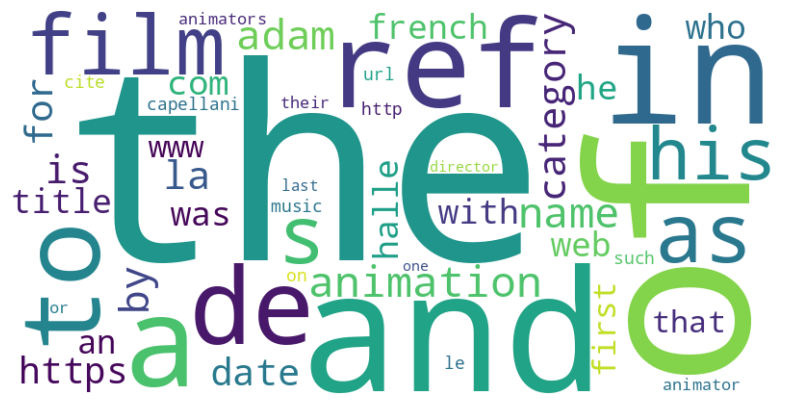

In [84]:
make_wordcloud(tokens1, 50)

In [23]:
def lengthOfLongestSubstring(s):
        """
        :type s: str
        :rtype: int
        """
        max_len = 0
        right = 1
        left = 0
        if len(s) == 1:
            return 1
        if len(s) == 0:
            return 0
        curr_chars = s[0]
        while right < len(s):
            print(str(right) +'\t'+str(left)+'\t'+curr_chars)
            if s[right] in curr_chars:
                max_len = max(max_len, len(curr_chars))
                while not s[left] == s[right]:
                    curr_chars = curr_chars.replace(s[left], '')
                    left += 1
                left += 1
            else:
                max_len = max(max_len, len(curr_chars))
                curr_chars += s[right]
            right += 1
        return max_len
lengthOfLongestSubstring('abced')

1	0	a
2	0	ab
3	0	abc
4	0	abce


4

In [ ]:
# Create histogram and boxplot for sentence length per category with min/max/avg

In [ ]:
# ?? Total number of bi-gram occurences per category. min/max/avg

In [ ]:
# Query rdf properties for 50 most frequent properties (I think this means predicates) and create word cloud

In [ ]:
# Create histograms and boxplot for number of facts per category. min/max/avg

In [ ]:
# Train KMeans clustering (n_clusters=2). Cluster based on text (?) and, separately, on facts

In [ ]:
# Compute supervised and unsupervised metrics and visualizations to compare results

In [ ]:
# Function that process a document and return the set of named entities(NEs) (Spacy)

In [ ]:
# Same as above but with Stanza

In [ ]:
# Get statistics for each output (avg/min/max number of NEs)

In [ ]:
# Get statistics for each output (avg/min/max number of words (unclear use of word 'word'))

In [ ]:
# Visualize the above 2 statistics (per category, per package)

In [ ]:
# Write a function that takes a single document and performs the following 5 tasks

In [ ]:
    # Returns # of spans that both packages agree on

In [ ]:
    # Returns # of partial agreements on spans

In [ ]:
    # Returns for each package # of spans that one package predicted as a NE and the other did not

In [ ]:
    # Returns for all spans with full and partial agreement, agreement about NE types (aka Person, Location, Organisation, etc.)

In [ ]:
    # Visualize the above statistics

In [ ]:
# For each set of NEs predicted by each package, how many of them can be found in the knowledge graph (KG)

In [ ]:
# For each package, the ratio of predicted NEs that can be found in the KG of a person

In [ ]:
# Bonus points